# PyCBC Inference Quick Overview #

This notebook provides a quick overview of the Bayesian inference tools in PyCBC. It is a combination of inference notebooks 1-6. For more details, see the separate tutorial notebooks.

Note that it's best to go through this tutorial in order as some sections may rely on earlier ones. 

* [1. Models](#1.-Models)
* [2. Estimating the distance of GW170817 ](#2.-Estimating-the-distance-of-GW170817)
* [3. Using the `pycbc_inference` command-line script](#3.-Using-the-pycbc_inference-command-line-script)
* [4. Plotting the posterior using `pycbc_inference_plot_posterior`](#4.-Plotting-the-posterior-using-pycbc_inference_plot_posterior)
* [5. Using waveform transforms in the config file](#5.-Using-waveform-transforms-in-the-config-file)
* [6. Estimate the masses of GW170817](#6.-Estimate-the-masses-of-GW170817)

### Make sure the software is set up ###


In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

## 1. Models

A `model` in pycbc inference represents the problem you are trying to solve. It contains the definition of the likelihood function you want to explore and details the parameters you are using. In this section, we'll walk through using models with pycbc inference and see how to create your own.

Let's see what models are available. All models are accessible via a dictionary in the `models` module. Each model has a unique name:

In [2]:
from pycbc.inference import models

for model_name in models.models:
    print(model_name)

test_eggbox
test_normal
test_rosenbrock
test_volcano
test_prior
gaussian_noise
marginalized_phase
marginalized_polarization
brute_parallel_gaussian_marginalize
single_template
relative


The models starting with `test_` are analytic models. These have predefined likelihood functions that are given by some standard distributions used in testing samplers. The other models are for gravitational-wave astronomy: they take in data and calculate a likelihood using an inner product between the data and a signal model. Currently, all of the gravitational-wave models in PyCBC assume that the data is stationary Gaussian noise in the absence of a signal. The difference between the models is they make varying simplfying assumptions, in order to speed up likelihood evaluation.

Below, we'll start with an analytic model to illustrate some basics of how PyCBC Inference works. We'll then use one of the simplified models to quickly estimate some parameters of GW170817.

### 1.1 One-dimensional Analytic Model ###

The simplest case is a problem with a single parameter. We'll go through how to estimate this parameter using an analytic model. In this case, we'll use the normal distribution.

Create an instance of a pre-made Model. This is an analytic model (i.e. no data used)
that we employ largely for testing the capabilities of different samplers. 
This will create a likelihood surface in one dimensions (x) with zero mean and unit variance

In [3]:
from pycbc.inference import models
from pycbc.distributions import Uniform

my_model = models.TestNormal(('x'), mean=(0))

We need to choose a sampler, in this case *emcee*. We need to provide the model we are
using along with the prior and number of walkers. Emcee is an 'ensemble' sampler so
it consists of many points which are traversing the space and help each other
explore the likelihood surface.

In [4]:
from pycbc.inference import sampler

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers=1000, nprocesses=8)

Before we start we need to decide the initial positions of the walkers
In this case we choose that they be distributed randomly between -1 and 1. We use the 'Uniform' distribution class. It is a common feature that these classes take the parameter name along with parameters that may define the distribution itself (such as bounds and other distribution-specific shape determining variables).

In [5]:
_ = engine.set_p0(prior=(Uniform(x=(-1, 1))))

Run the mcmc for 200 iterations

In [6]:
engine.run_mcmc(200)

We can get the entire history of where the "walkers" have been by looking at the samples
attribute. For each variable parameter, we get an array with 
dimensions nwalkers x num_iterations. This is the format for the 'Emcee' sampler. Other samples may have other formats for their parameter chains. For example, parallel tempered samplers will have an additional dimension which represents the temperature. 

In [7]:
import pylab, numpy

xchain = engine.samples['x']

The chain has 2 dimensions, the first axis is the walker
and the second is the iteration.
We'll plot the final position of each walker

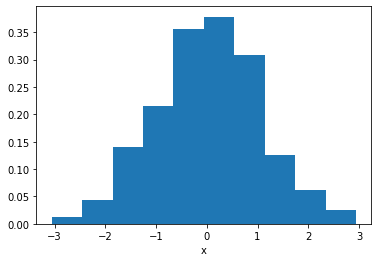

0.015325226194132815 1.0747474757761784


In [8]:
values = xchain[:,-1]  
pylab.hist(values, density=True)
pylab.xlabel('x')
pylab.show()
print(values.mean(), numpy.var(values))

####  Suggested Problem ####

Try changing the mean of the analytic distribution. We've provided a random number below (no peaking!) What do you estimate for the mean of the distribution? 

In [9]:
from numpy.random import uniform, seed
seed(0)
a_number = uniform(-100, 100)

### 1.2 Using a model with priors ###

You may have noticed that in the previous example we did not specify any prior. If you do not specify a prior, a flat prior (with no boundaries) will be used. Let's now specify a prior. To do so, we will use the [distributions](http://pycbc.org/pycbc/latest/html/pycbc.distributions.html#pycbc-distributions-package) package. This contains many pre-made pdfs which can be used to build a prior. In fact we've been using this already to set initial walker positions.

In [10]:
from pycbc.distributions import Uniform

Let's create a prior on our variable that is uniform between $[0, 10)$. The resulting posterior should be a truncated normal distribution.

In [11]:
prior_x = Uniform(x=(0, 10))

In order to provide the prior to the model, we need to wrap it in a [JointDistribution](http://pycbc.org/pycbc/latest/html/pycbc.distributions.html#pycbc.distributions.joint.JointDistribution). The JointDistribution provides a common API for the models to evaluate the prior at a given point. If we had a problem with multiple parameters, each with their own prior distribution, we could provide the different distributions `JointDistribution`; it will take the product over all the distributions, providing the model a single number for the prior pdf. The `JointDistribution` also allows you to provide arbitrary constraints on parameters, although we will not cover that here.

In [12]:
from pycbc.distributions import JointDistribution

prior = JointDistribution(['x'], prior_x)

# Prior is a standard keyword that models which inherit from BaseModel 
# can take.
my_model = models.TestNormal('x', prior=prior)

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers=1000, nprocesses=8)

# Note that we do not need to provide anything to `set_p0` to set the initial positions
# this time. By default, the sampler will draw from the prior in this case.
engine.set_p0()
engine.run_mcmc(400)

Since the `TestNormal` model's likelihood has zero mean and unit variance, forcing $x$ to only accept positive values via the prior means that our posterior should be a $\chi$ distribution with 1 degree of freedom. Let's check:

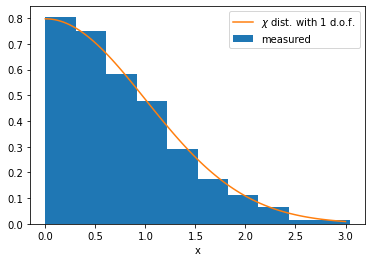

In [13]:
import pylab, numpy

xchain = engine.samples['x']
values = xchain[:,-1]  

pylab.figure()
pylab.hist(values, density=True, label='measured')

from scipy import stats
xpts = numpy.linspace(0, 3, num=100)
y = stats.chi.pdf(xpts, 1.)
pylab.plot(xpts, y, label='$\chi$ dist. with 1 d.o.f.')

pylab.xlabel('x')
pylab.legend()

####  Suggested Problem ####

Try changing the prior for this problem. How does it change the resulting distribution?

## 2. Estimating the distance of GW170817 ##

Now that we have some experience with models in pycbc inference, let's take a look at some of the existing models that pycbc inference provides targeted at gravitational-wave data analysis. We'll start with the `SingleTemplate` model. This model is useful when we know the intrinsic parameters of a source (i.e. component masses, spins), but we don't know the extrinsic parameters (i.e. sky location, distance, binary orientation). This will allow us to estimate the distance to GW170817 and the inclination of the orbital plane from our viewing angle. 

This model requires a specifc set of data products.
  * Dictionary of frequency-domain data (keyed by observatory short name such as 'H1', 'L1', 'V1').
  * Dictionary of power spectral density estimates
  * Low frequency cutoff to use for internal filtering in the model
  
We will make use of PyCBC gw signal processing tools to prepare this data.

In [14]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 
        'V1', 
        'L1',
       ]

# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True)
    data_filenames[ifo] = fname

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd


Processing H1 data
Processing V1 data
Processing L1 data


A number of parameters must also be provided as 'static' parameters. These include 
   * mass1 (Units in solar masses)
   * mass2 (Units in solar masses)
   * f_lower (used for where to start our gravitational waveform model generation from)
   * approximant (This sets which waveform model we are using)

If a model supports other intrinsic parameters (such as components spins), they may 
also optionally be provided.

There are also a fixed set of 'variable' parameters. These are the only ones which we
can obtain estimates of with this model. These are
   * ra        (Units in radians)
   * dec       (Units in radians)
   * distance  (Units in Megaparsecs)
   * inclination (Units in radians)
   * polarization (Units in radians)
   * tc           (Units in seconds): This parameter is roughly the time of merger.
   
It's important to note that anything which could be a variable paramater, can be transformed
into a static parameter by supplying a specific value for it. We take advantage of this below
to limit our analyis to only sample over 'distance', 'inclination', and 'tc'. We set the sky location
to the location of NGC 4993, the galaxy where an electromagnetic counterpart to GW170817 was observed.

In [15]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy

static = {'mass1':1.3757,
          'mass2':1.3757,
          'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'ra': 3.44615914,
          'dec': -0.40808407
         }

variable = ('distance',
            'inclination',
            'tc')

inclination_prior = SinAngle(inclination=None)
distance_prior = Uniform(distance=(10, 100))
tc_prior = Uniform(tc=(m.time-0.1, m.time+0.1))

prior = JointDistribution(
    variable, inclination_prior, distance_prior, tc_prior)

We are not ready to create our SingleTemplate model instance. Note how the variable and static parameters
are passed to the model. This is a common way this information can be passed for built-in pycbc inference models.

Notice that we are no longer using the Emcee sampler. While Emcee is sufficient for many problems, EmceePT, a parallel tempered version of Emcee is more effective at most gravitational-wave data analysis problems. There is one additional parameter we need to give to EmcceePT which is the number of temperatures. The output of this sampler will thus be 3-dimensional (temps x walkers x iterations). The 'coldest' temperature (0) will contain our actual results. 

In [16]:
import copy
model = models.SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl = sampler.EmceePTSampler(model, 3, 200, nprocesses=8)
_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

In [17]:
# Note it may take ~1-3 minutes for this to run
smpl.run_mcmc(200)

In addition to the sampled parameters, we can also get the likelihood values our model produces. We don't go into it here, but it is also possible for models to make arbitary auxiliary information about each sample available.

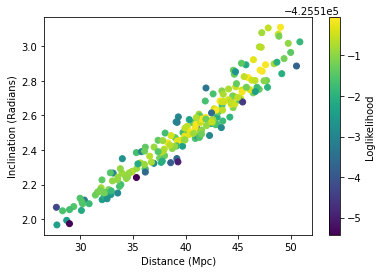

In [18]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

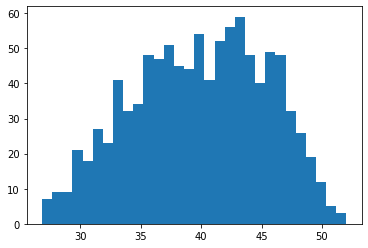

In [19]:
_ = pylab.hist(s['distance'][0,:,-100::20].flatten(), bins=30)

#### 2.1 Watch how the position of the walkers evolves in time ###

We can see how our ensemble of walkers evolves with time using the animation utilities of matplotlib. We haven't covered the concept of "burn-in" in this tutorial, however, if you watch the animation, you can see the point
that the distribution is effectively burned-in.

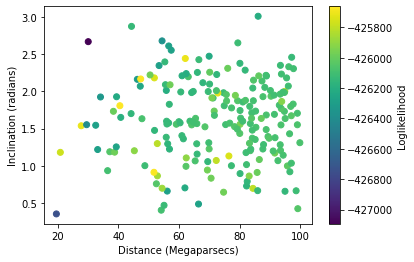

In [20]:
%matplotlib inline
from matplotlib import animation
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(10)
a = pylab.scatter(s['distance'][0,:,0],
                  s['inclination'][0,:,0],
                  c=lik[0,:,0])
pylab.xlabel('Distance (Megaparsecs)')
pylab.ylabel('Inclination (radians)')
c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['distance'][0,:,i], s['inclination'][0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(s['distance'][0,0,:])
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

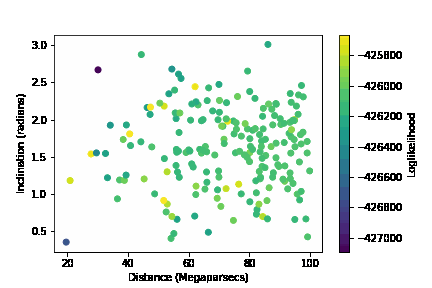

In [21]:
from matplotlib.animation import PillowWriter
from IPython.display import Image

# Note to get this to play, you may need to right click on the image and
# download to your computer or open the image in a new tab of your browser
ani.save('move.gif', writer=PillowWriter(fps=5))
with open('move.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

####  Suggested Problems ####

1. If we exclude Virgo and Livingston how is the recovery of distance and inclination affected? How about if we just exclude Virgo? Hint: you can do this by modifying the 'ifos' list of the first cell in this section. 
2. GW170817 was identified with a counterpart in NGC4993. If we use the distance to NG4993 as a prior (41 +-3 Mpc) can we improve our estimate of the source binary inclination? Try setting a Gaussian prior based on this additional information.
3. How well measured is the time of coalesence ('tc') ?
3. (For the curious) Try the EmceeSampler like we've used in previous examples. How do the results compare after the same number of iterations? Note, remember that the Emcee and EmceePT samplers don't have the same format sample chains. Ecmee uses a walker x iteration chain, while EmceePT will have a temp x walker x iteration format.


## 3. Using the `pycbc_inference` command-line script

The examples above illustrated how the models and samplers are used in the inference module. While this is useful for quick checks, it's not feasible to do large-scale parameter estimation problems in a jupyter notebook. Instead, when actually doing parameter estimation, we use the command-line script `pycbc_inference`. This pulls together the sampler, models, and distributions modules so that we may perform Bayesian inference.

The key arguments that `pycbc_inference` takes are an output file and one or more `config-files` (run `pycbc_inference --help` to see all of the arguments it takes). The config files entirely specify the problem that you will be analyzing. In them, you specify the model to use, the variable parameters, and the prior on each of the parameters. If the model involves gravitational-wave data, you also specify what data to load and how to estimate the PSD. To see how this works, let's repeat the above analysis where we estimate the distance and inclination of GW170817 using the `SingleTempate` model.

### 3.1 Setting up the config file ###

*Note: in order to do everything from within the notebook, we'll create the config files by echoing a python string to  a file. In a normal situation, you would just use your favorite text editor to create the config files.*

#### The model

In [22]:
model_config = """
[model]
name = single_template
low-frequency-cutoff = 25.
sample_rate = 8192
"""

In [23]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = single_template
low-frequency-cutoff = 25.
sample_rate = 8192



#### The data

Since this model uses data, we also need to create a data section that specifies what data to read for the analysis and the PSD estimation. See the [PyCBC Inference docs](https://pycbc.org/pycbc/latest/html/inference.html#setting-data) for more information about what options are available and what they mean.

In [24]:
data_config = """
[data]
instruments = H1 L1 V1
trigger-time = {event_tc}
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 15
pad-data = 8
sample-rate = 2048
frame-files = H1:{h1file} L1:{l1file} V1:{v1file}
channel-name = H1:LOSC-STRAIN L1:LOSC-STRAIN V1:LOSC-STRAIN
""".format(event_tc=Merger("GW170817").time,
           h1file=data_filenames['H1'],
           l1file=data_filenames['L1'],
           v1file=data_filenames['V1'])

In [25]:
!echo '{data_config}' > data.ini
!cat data.ini


[data]
instruments = H1 L1 V1
trigger-time = 1187008882.4
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 15
pad-data = 8
sample-rate = 2048
frame-files = H1:/Users/cdcapano/.astropy/cache/download/url/c484b43c2c76aaf6fca1a057f4d6ed52/contents L1:/Users/cdcapano/.astropy/cache/download/url/9bb63179cc5cca254380aeb2ee25fd0d/contents V1:/Users/cdcapano/.astropy/cache/download/url/51cfa540d575027e191b029fedbda5db/contents
channel-name = H1:LOSC-STRAIN L1:LOSC-STRAIN V1:LOSC-STRAIN



#### The prior
Now let's specify the prior. We need to provide a section that lists the variable parameters and another that specifies the static parameters. For every variable parameter we have to provide one or more `prior` section(s) that specifies the prior distribution.

In [26]:
prior_config = """
[variable_params]
distance =
inclination =
delta_tc =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407

[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [27]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
distance =
inclination =
delta_tc =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407

[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



*But wait!* There's something odd here: the list of variable parameters contains a `delta_tc`, whereas we need to provide a `tc` for the coalescence time. This illustrates that the `variable_params` can be anything we like them to be with any name (we could of called `delta_tc` `foobar` if we liked). They do not need to be predefined in code anywhere. However, the waveform models do need specific parameters to be provided in order to generate a template waveform. If we use a parameter that is not recognized by the waveform model (see [here](https://pycbc.org/pycbc/latest/html/inference.html#waveform-transforms) for a list of known parameters), then we must provide a `waveform_transforms` section that tells the code how to convert that parameter into something that the waveform model recognizes. In this case, `delta_tc` is not recognized by the waveform model, but `tc` is. So, we've provided a section that converts `delta_tc` into `tc` by adding the trigger time. Also note that when providing the trigger time we used `${data|trigger-time}`. We can use variable substitution in config files. In this case, we've told the config file to get the trigger time that's stored in the `[data]` section. This illustrates why we've chosen to make `delta_tc` the variable parameter: we do not need to copy and paste hard-to-read GPS times all over the place. Instead, we only need provide a time in one location, then refer to it elsewhere. This makes it clear and easy to specify the tc prior, which is just a uniform window +/- 0.1s around the estimated time. Another advantage of this is we could analyze other events using the same prior file, just swapping out data files.

We will see some other, more advanced uses of waveform transforms below.

#### The sampler

Finally, we need to specify the sampler settings. To do that, we need to provide a `sampler` section.

In [28]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""

In [29]:
!echo '{sampler_config}' > sampler.ini
!cat sampler.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



Note that we've also provided a burn-in test. Here, we're telling it just use the second half of the chain. This means that at the end of the run, it will consider the second half of the chains to be post-burn in. An autocorrelation time will be computed over this and a posterior extracted. More sophisticated burn-in tests are available; see the [pycbc.inference.burn_in module](https://pycbc.org/pycbc/latest/html/pycbc.inference.html#module-pycbc.inference.burn_in) for more details.

### 3.2 Run `pycbc_inference`

Now that we've set up our config files, we can run `pycbc_inference`:

In [30]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference.hdf \
    --seed 28572013 \
    --nprocesses 8 \
    --force    

2020-11-17 17:32:02,307 Using seed 28572013
2020-11-17 17:32:02,307 Running with CPU support: 1 threads
2020-11-17 17:32:02,307 Reading configuration file
2020-11-17 17:32:02,310 Setting up model
2020-11-17 17:32:02,311 Setting up priors for each parameter
2020-11-17 17:32:02,312 No sampling_params section read from config file
2020-11-17 17:32:02,312 Loading waveform transforms
2020-11-17 17:32:02,314 Determining analysis times to use
2020-11-17 17:32:02,314 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2020-11-17 17:32:02,314 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2020-11-17 17:32:02,314 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2020-11-17 17:32:02,315 Reading Frames
2020-11-17 17:32:05,999 Highpass Filtering
2020-11-17 17:32:06,053 Converting to float64
2020-1

Now that it's done, we can see that an `inference.hdf` file exists in our directory:

In [31]:
!ls -lh inference.hdf

-rw-r--r--  1 cdcapano  staff    75M Nov 17 17:33 inference.hdf


This contains all of the samples, and the information needed to extract the posterior from it, along with other diagnostic information about the sampler. Below, we show how to plot a posterior from this.

## 4. Plotting the posterior using `pycbc_inference_plot_posterior`

The command-line tool `pycbc_inference_plot_posterior` is used to make corner and posterior plots of our results. We can give it either the direct output of `pycbc_inference` (here, `inference.hdf`) or a posterior file created using `pycbc_inference_extract_samples`. There are several plotting configuration options available (see `pycbc_inference_plot_posterior --help` for the list of options). Here we'll illustrate a few.

### 4.1 Corner scatter plot
Let's create a corner plot of our results. We'll show every sample in our posterior colored by the signal-to-noise ratio (here defined as $\sqrt{2\mathcal{L}}$ where $\mathcal{L}$ is the log likelihood ratio).

In [32]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr

2020-11-17 17:33:06,785 Reading input file inference.hdf
2020-11-17 17:33:06,786 Loading samples
2020-11-17 17:33:06,790 Loaded 1400 samples
2020-11-17 17:33:06,791 Getting samples for colorbar
2020-11-17 17:33:06,794 Plotting
2020-11-17 17:33:08,134 Done


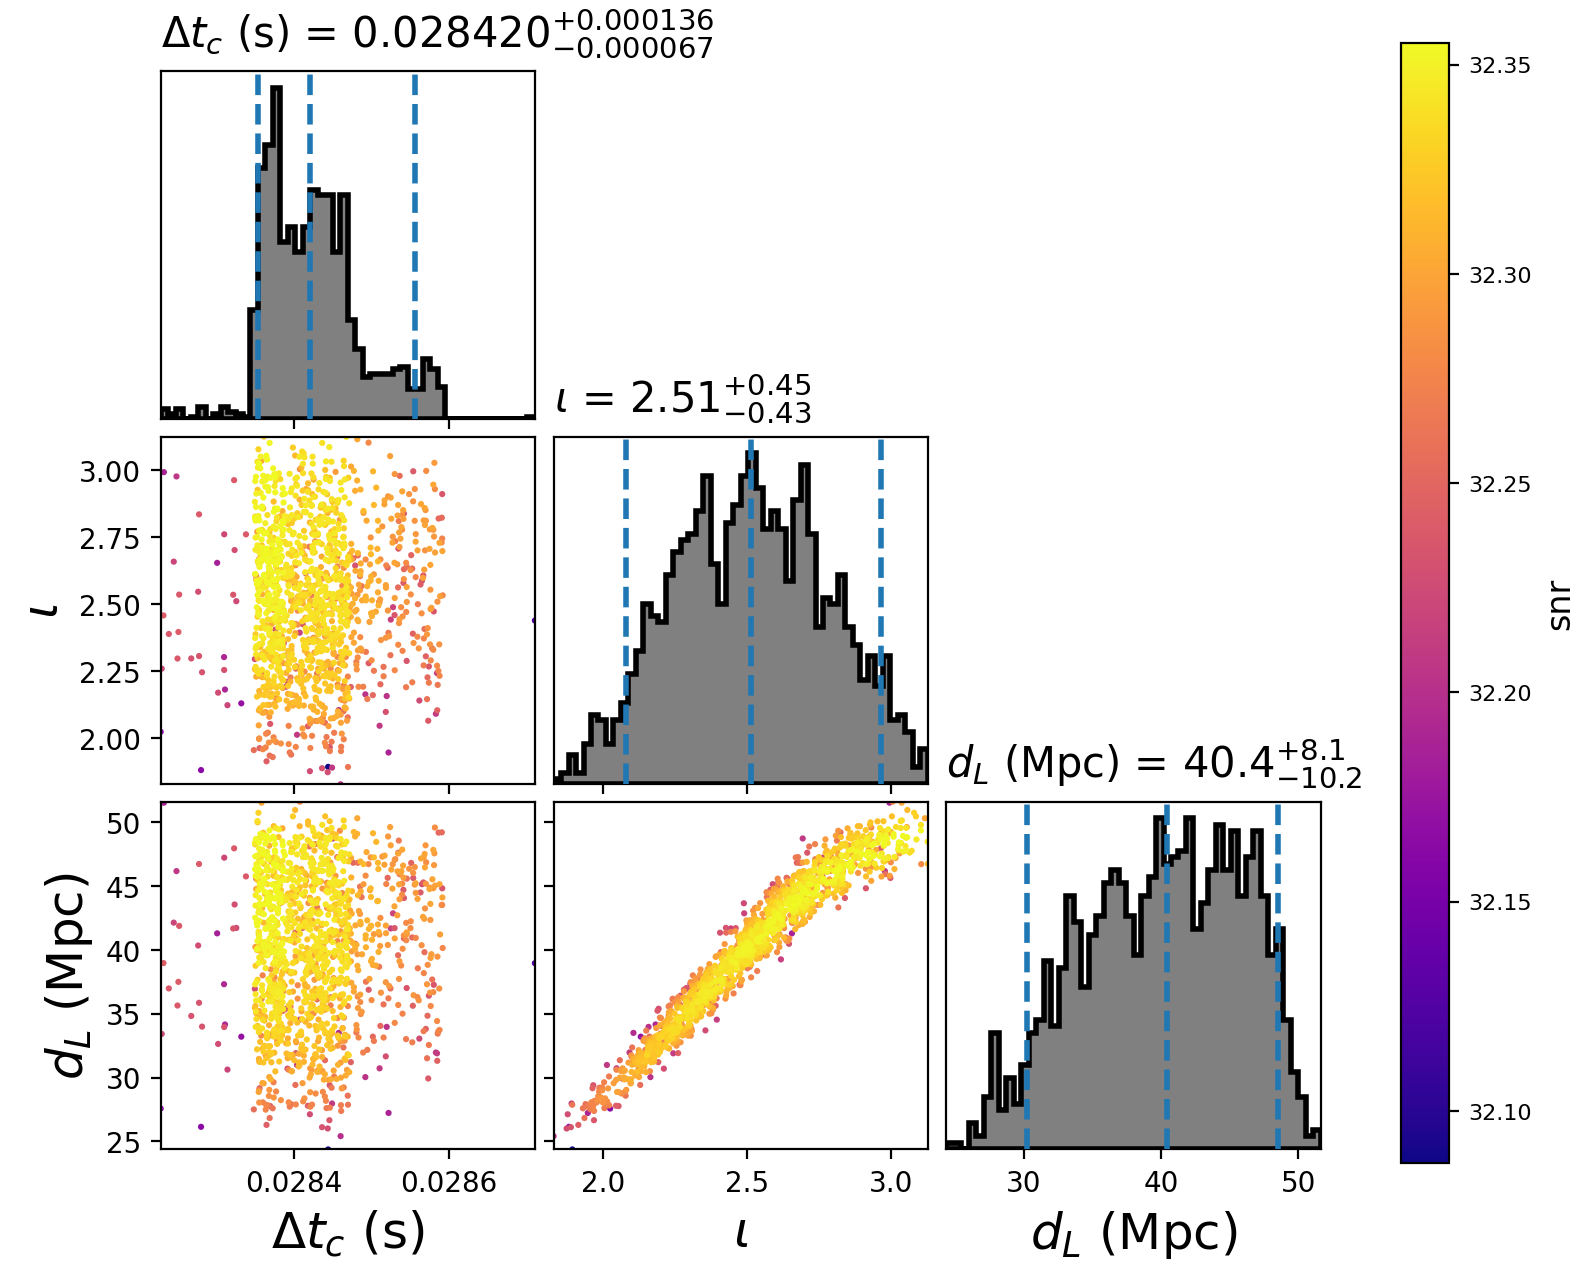

In [33]:
Image('posterior.png')

### 4.2 2D density plot

By default, we see that it has plotted all of the `variable_params`. Let's just plot distance vs inclination instead. We can do that via the `--parameters` argument. Let's also make a density plot with 2D marginal contours rather than a scatter plot. We'll do that by dropping the `--plot-scatter` and `--z-arg` commands, adding `--plot-density` and `--plot-contours` instead.

In [34]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference.hdf \
    --output-file posterior-dist_inc.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters inclination distance

2020-11-17 17:33:09,980 Reading input file inference.hdf
2020-11-17 17:33:09,981 Loading samples
2020-11-17 17:33:09,986 Loaded 1400 samples
2020-11-17 17:33:09,986 Plotting
2020-11-17 17:33:11,256 Done


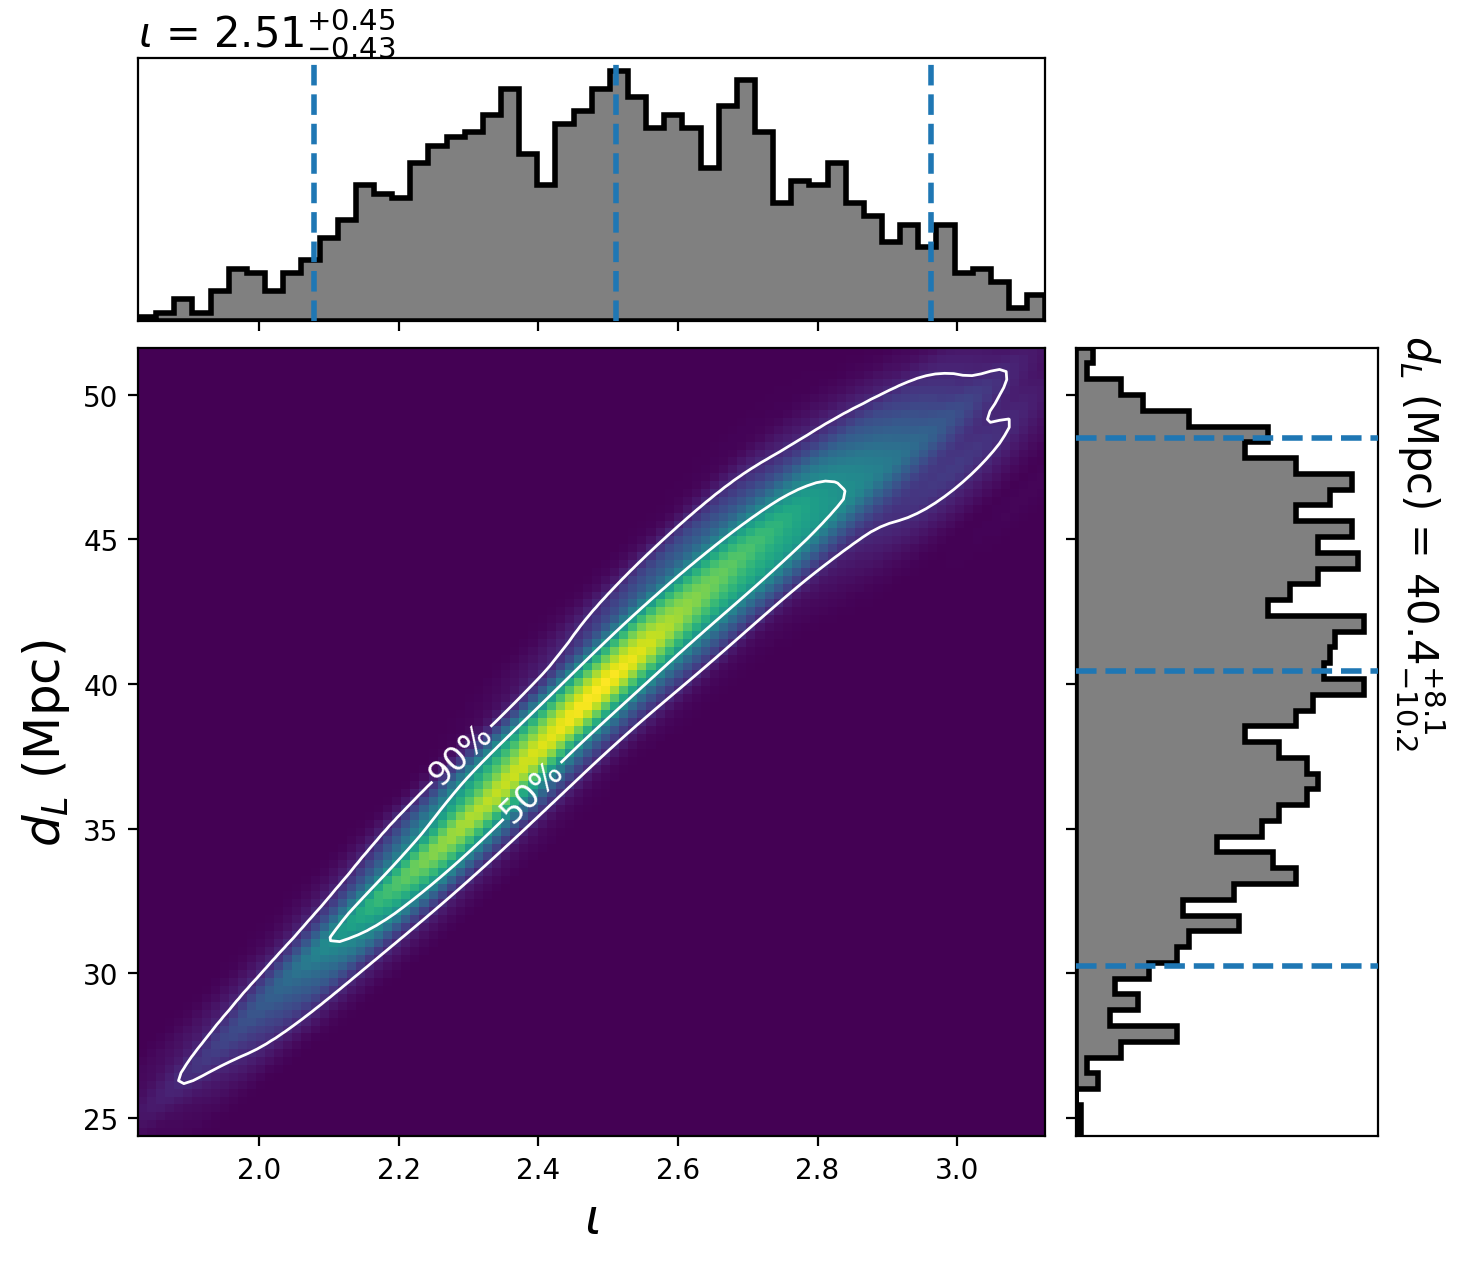

In [35]:
Image('posterior-dist_inc.png')

### 4.3 Manipulating parameters on the command line

The `--parameters` can be used to do more than just turn certain parameters on or off. We can also apply math functions to parameters using standard python syntax. Any numpy function may be used. Functions from the  [pycbc.conversions](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.conversions), [pycbc.coordinates](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.coordinates), or [pycbc.cosmology](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.cosmology) modules are also available. To see all of the parameters in our results file, along with all the functions that may be carried out on them, we can use the `--file-help` argument. This will print a message to screen then exit:

In [36]:
!pycbc_inference_plot_posterior --input-file inference.hdf --file-help


Parameters available with this (these) input file(s):

delta_tc distance inclination logjacobian loglikelihood logprior

Available pycbc functions (see http://pycbc.org/pycbc/latest/html for
more details):

cartesian_to_spherical, cartesian_to_spherical_azimuthal,
cartesian_to_spherical_polar, cartesian_to_spherical_rho, chi_a,
chi_eff, chi_eff_from_spherical, chi_p, chi_p_from_spherical,
chi_p_from_xi1_xi2, chi_perp_from_mass1_mass2_xi2,
chi_perp_from_spinx_spiny, chirp_distance,
cosmological_quantity_from_redshift, det_tc,
distance_from_comoving_volume, dquadmon_from_lambda,
eta_from_mass1_mass2, eta_from_q, eta_from_tau0_tau3,
final_mass_from_f0_tau, final_mass_from_initial,
final_spin_from_f0_tau, final_spin_from_initial,
freq_from_final_mass_spin, invq_from_mass1_mass2,
lambda_from_mass_tov_file, lambda_tilde, mass1_from_mass2_eta,
mass1_from_mchirp_eta, mass1_from_mchirp_q, mass1_from_mtotal_eta,
mass1_from_mtotal_q, mass1_from_tau0_tau3, mass2_from_mass1_eta,
mass2_from_mchirp_

One of the available functions, [redshift](https://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.cosmology.redshift), takes in luminosity distance and converts it to redshift assuming a standard cosmology. Let's use that, and some of the numpy functions, to plot redshift versus inclination angle in degrees. Let's also add a line at the redshift of [NGC4993](https://en.wikipedia.org/wiki/NGC_4993) to see how well our results agree. We'll do that using the `--expected-parameters` command.

In [37]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference.hdf \
    --output-file posterior-redshift_inc.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters 'inclination*180/pi:$\iota$ (deg)' 'redshift(distance):redshift' \
    --expected-parameters 'redshift(distance):0.009727'

2020-11-17 17:33:14,800 Reading input file inference.hdf
2020-11-17 17:33:14,801 Loading samples
2020-11-17 17:33:14,806 Loaded 1400 samples
2020-11-17 17:33:15,459 Plotting
2020-11-17 17:33:16,763 Done


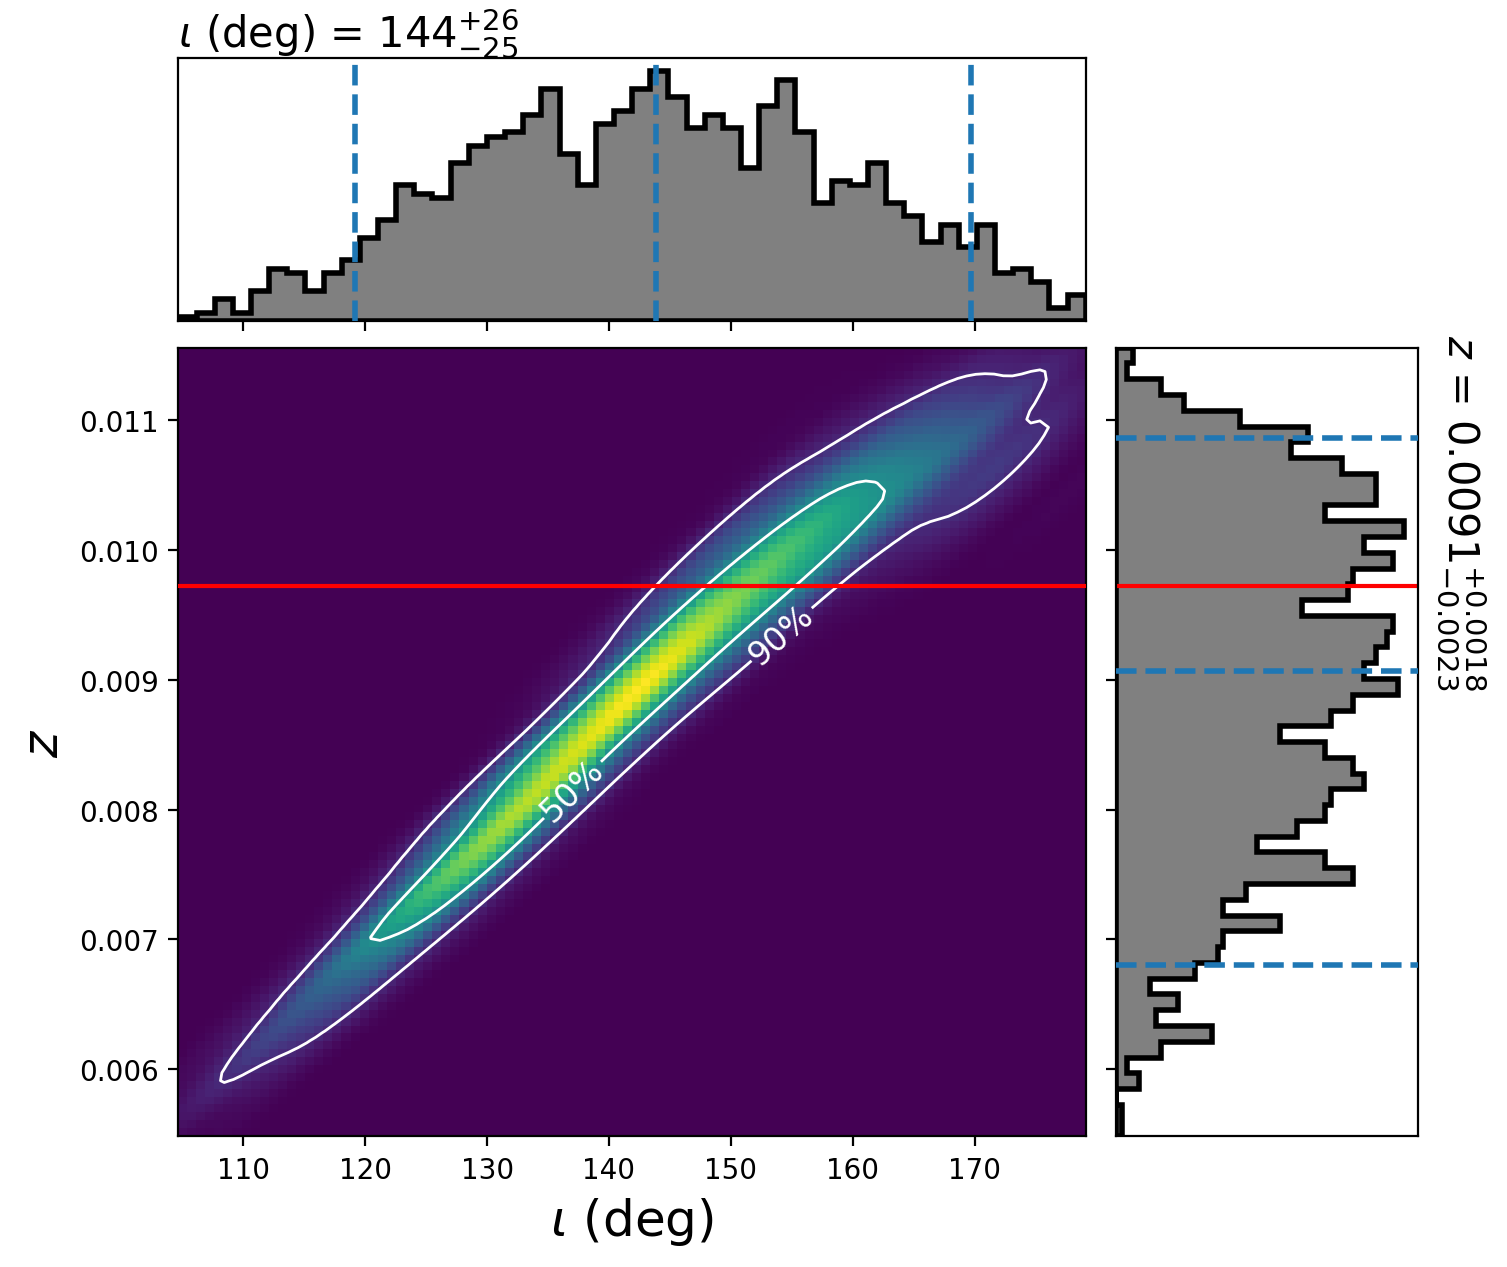

In [38]:
Image('posterior-redshift_inc.png')

## 5. Using waveform transforms in the config file

The functions available to the `--parameters` argument of `pycbc_inference_plot_posterior` are actually used throughout the `inference` module (if you're curious, this is made possible via [FieldArrays](https://pycbc.org/pycbc/latest/html/pycbc.io.html#pycbc.io.record.FieldArray), which is a custom wrapping of numpy record arrays; see the `inference_5_results_io` notebook for more details). Of particular note, you can use the same set of functions in the `waveform_transforms` section(s) of the config file. This allows you to carry out more complicated inference without needing to modify the PyCBC source code.

To illustrate this, let's modify the prior in the above problem to use a prior uniform in comoving volume rather than a prior uniform in distance.

First, we'll need boundaries for our comoving volume prior. Let's use the cosmology module to get the comoving volume corresponding to a luminosity distance of 10 and 100 Mpc:

In [39]:
from pycbc import cosmology

vmin, vmax = cosmology.cosmological_quantity_from_redshift(cosmology.redshift([10., 100.]), 'comoving_volume')
print(vmin, vmax)

4160.561734509789 3921535.7960404437


Now let's modify our prior. We'll swap `distance` for `comoving_volume`. Since the waveform's require luminosity distance, we'll provide a waveform transform that uses the [distance_from_comoving_volume](https://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.cosmology.distance_from_comoving_volume) function in the cosmology module:

In [40]:
prior_config = """
[variable_params]
comoving_volume =
inclination =
delta_tc =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407

[prior-comoving_volume]
name = uniform
min-comoving_volume = 4160
max-comoving_volume = 3921536

[waveform_transforms-distance]
name = custom
inputs = comoving_volume
distance = distance_from_comoving_volume(comoving_volume)

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [41]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
comoving_volume =
inclination =
delta_tc =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407

[prior-comoving_volume]
name = uniform
min-comoving_volume = 4160
max-comoving_volume = 3921536

[waveform_transforms-distance]
name = custom
inputs = comoving_volume
distance = distance_from_comoving_volume(comoving_volume)

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



### Suggested problems:
 1. Rerun the above script (starting from section 3.2) with the uniform in comoving volume prior. Note that when you plot the posterior, you'll get `comoving_volume` if you do not provide a `--parameters` argument. Add the parameters argument to plot distance instead. Do the same for redshift.
 2. Repeat, but estimate the sky location. To do this, you'll want to move `ra` and `dec` into the `[variable_params]`. What prior should you use? Take a look at the [list of available distributions](https://pycbc.org/pycbc/latest/html/inference.html#configuring-the-prior). Answer [here](https://github.com/gwastro/pycbc/blob/v1.16.12/examples/inference/priors/bbh-uniform_comoving_volume.ini#L160-L161) (no peaking!)

## 6. Estimate the masses of GW170817 ##

In the previous example we quickly estimated the extrinsic parameters of GW170817 by fixing the intrinsic. This was fast, since it did not require regenerating a waveform for each likelihood evaluation. Now let's try estimating the masses of GW170817. This is generally slower, since it requires generating a waveform on each likelihood call. However, in the example below, we'll use the [relative binning model](https://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.relbin.Relative). This uses a technique presented in [Zackay et al.](https://arxiv.org/abs/1806.08792). Basically, a reference waveform is used that's close to the peak likelihood. A linear approximation is used to interpolate the likelihood around this waveform, reducing the number of frequency points that we need to evaluate, and speeding up the analysis.

To do this, we'll use the same `data.ini` and `sampler.ini` files as above. We'll change the `model` to the `relative` one and provide the necessary arguments to generate the fiducial waveform. We'll make `mass1` and `mass2` the variable parameters; for speed, we'll fix the extrinsic parameters.

### 6.1 Get the extrinsic parameters

For speed, we'll fix the extrinsic parameters. We'll use our previous results using the `SingleTemplate` model to get the maximum likelihood values of the distance, inclination, and coalescence time. To do that, we'll use `pycbc_inference_table_summary` to print out a table of the values.

In [42]:
!pycbc_inference_table_summary \
    --input-file inference.hdf \
    --output-file posterior_summary.html \
    --verbose

2020-11-17 17:33:19,597 Reading input file inference.hdf
2020-11-17 17:33:19,598 Loading samples
2020-11-17 17:33:19,606 Loaded 1400 samples


In [43]:
from IPython.display import HTML
HTML('posterior_summary.html')

Parameter,90% Credible Interval,Maximum Posterior,Maximum Likelihood
$\iota$,$2.51^{+0.45}_{-0.43}$,$2.45$,$2.92$
$d_L$ (Mpc),$40.4^{+8.1}_{-10.2}$,$39$,$47.7$
$\Delta t_c~(\rm{s})$,$0.028420^{+0.000136}_{-0.000067}$,$0.028376$,$0.028376$


### 6.1 Setup the config files

In [44]:
model_config = """
[model]
name = relative
low-frequency-cutoff = 25.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 1.3757
mass2_ref = 1.3757
tc_ref = ${data|trigger-time}
"""

In [45]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = relative
low-frequency-cutoff = 25.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 1.3757
mass2_ref = 1.3757
tc_ref = ${data|trigger-time}



In [46]:
prior_config = """
[variable_params]
mass1 =
mass2 =

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407
distance = 48
inclination = 3
delta_tc = 0.028365

[prior-mass1]
name = uniform
min-mass1 = 1
max-mass1 = 2

[prior-mass2]
name = uniform
min-mass2 = 1
max-mass2 = 2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [47]:
prior_config = """
[variable_params]
mchirp =
eta =

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407
distance = 48
inclination = 3.0
delta_tc = 0.028365

[prior-mchirp]
name = uniform
min-mchirp = 1.1876
max-mchirp = 1.2076

[prior-eta]
name = uniform
min-eta = 0.23
max-eta = 0.25

[waveform_transforms-mass1+mass2]
; transform from mchirp, eta to mass1, mass2 for waveform generation
name = mchirp_eta_to_mass1_mass2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [48]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
mchirp =
eta =

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407
distance = 48
inclination = 3.0
delta_tc = 0.028365

[prior-mchirp]
name = uniform
min-mchirp = 1.1876
max-mchirp = 1.2076

[prior-eta]
name = uniform
min-eta = 0.23
max-eta = 0.25

[waveform_transforms-mass1+mass2]
; transform from mchirp, eta to mass1, mass2 for waveform generation
name = mchirp_eta_to_mass1_mass2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



### 6.2 Run

*Note: this may take several minutes to run.*

In [49]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference-masses.hdf \
    --seed 3214897 \
    --nprocesses 8 \
    --force    

2020-11-17 17:33:21,712 Using seed 3214897
2020-11-17 17:33:21,712 Running with CPU support: 1 threads
2020-11-17 17:33:21,712 Reading configuration file
2020-11-17 17:33:21,714 Setting up model
2020-11-17 17:33:21,715 Setting up priors for each parameter
2020-11-17 17:33:21,715 No sampling_params section read from config file
2020-11-17 17:33:21,716 Loading waveform transforms
2020-11-17 17:33:21,719 Determining analysis times to use
2020-11-17 17:33:21,719 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2020-11-17 17:33:21,719 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2020-11-17 17:33:21,719 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2020-11-17 17:33:21,720 Reading Frames
2020-11-17 17:33:25,332 Highpass Filtering
2020-11-17 17:33:25,385 Converting to float64
2020-11

### 6.3 Plot the posterior

In [50]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-masses.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr \
    --parameters mchirp eta

2020-11-17 17:35:11,986 Reading input file inference-masses.hdf
2020-11-17 17:35:11,988 Loading samples
2020-11-17 17:35:11,995 Loaded 1800 samples
2020-11-17 17:35:11,995 Getting samples for colorbar
2020-11-17 17:35:11,999 Plotting
2020-11-17 17:35:12,307 Substituting symbol M from STIXNonUnicode
2020-11-17 17:35:12,376 Substituting symbol M from STIXNonUnicode
2020-11-17 17:35:12,585 Substituting symbol M from STIXNonUnicode
2020-11-17 17:35:12,630 Substituting symbol M from STIXNonUnicode
2020-11-17 17:35:13,240 Done


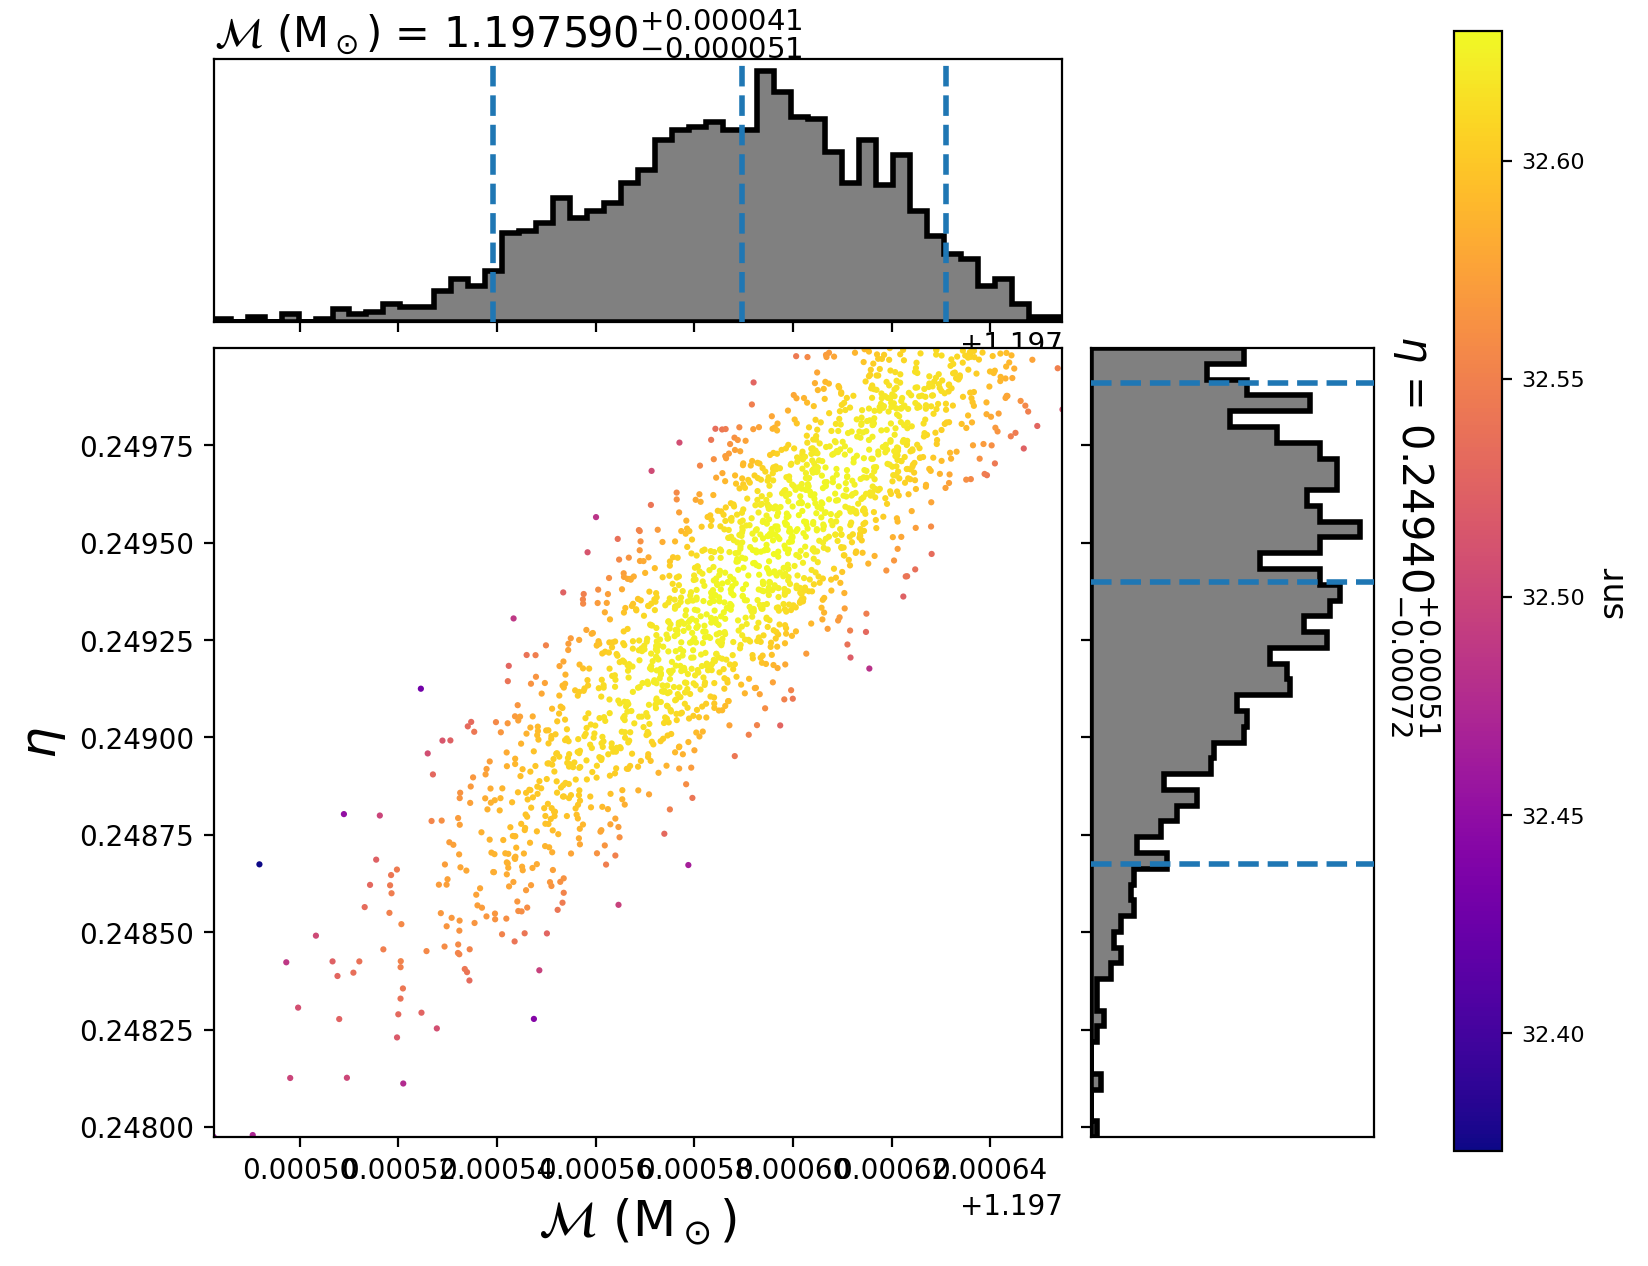

In [51]:
Image('posterior.png')

### Suggested problems:
 1. Plot source-frame chirp mass instead.
 2. Repeat the above, but use a prior uniform in mass1 and mass2. Do the results look converged after just 400 iterations? If not, try increasing the number of iterations. Also try increasing the number of temperatures. Note that this will take longer to analyze as a result. When plotting the results, notice that there are points where mass2 > mass1. Replot with mass1 > mass2. You can do that by using the `primary_mass` and `secondary_mass` functions.
 3. Repeat the same, but use a prior uniform in source-frame masses. See the example BBH prior config [here](https://github.com/gwastro/pycbc/blob/v1.16.12/examples/inference/priors/bbh-uniform_comoving_volume.ini) for help.